# A Novel Objective Function Based on a Generalized Kelly Criterion for Deep Learning

*Faezeh Fallah, Doychin Mariyanov Tsanev, Bin Yang, Sven Walter, Fabian Bamberg*
*A Novel Objective Function Based on a Generalized Kelly Criterion for Deep Learning*
*Proceedings of the IEEE Conference on Signal Processing, Algorithms, Architectures,* *Arrangements, and Applications (SPA), September 2017, Poznan, Poland*

### Concepts

- Training sample: $v_i$ with win probabilities $\mathbf{p}_{v_{i}}=\left(p_{v_{i}}^{1}, p_{v_{i}}^{2}, \ldots, p_{v_{i}}^{|C|}\right)$ for all possible classes $c\in C$
- Beliefs (odds): $b_{v_{i}}^{c}$ observed by bettor for each class $c\in C$
- Revenue rate: $r_{v_{i}}^{c}=1 / b_{v_{i}}^{c}$
- Expected revenue: $e r_{v_{i}}^{c}=p_{v_{i}}^{c} / b_{v_{i}}^{c}$ (weighted with probability)
- Allocation fraction: $f_{v_{i}}^{c}$ for sample $v_i$ and for each $c\in C$

### Generalized Kelly Criterion
- Wealth grow factor: $$
\lim _{T \rightarrow \infty} L_{v_{i}}^{t}=L_{v_{i}}=\sum_{c \in C}\left(p_{v_{i}}^{c} \cdot \ln \left(1-\sum_{k \in C} f_{v_{i}}^{k}+r_{v_{i}}^{c} \cdot f_{v_{i}}^{c}\right)\right)
$$

- Constrains $$
P_{v_{i}}=\left\{\mathbf{f}_{v_{i}} \in S_{v_{i}} \mid \sum_{c \in C} f_{v_{i}}^{c} \lt 1 \text { and } \forall c \in C, f_{v_{i}}^{c} \geq 0\right\}
$$


- We maximize $L_{v_{i}}$ not as an objective function as in Kelly based betting, rather as a means to identify the optimum classes $C_{v_{i}}^{\text {opt}} \subseteq C$ on which we should bet and the optimal allocation fractions for each training sample $v_i$

### Determine optimum classes $C_{v_{i}}^{\text {opt}}$ and allocation fractions $f_{v_{i}}^{c}$ for each training sample $v_i$

- Maximizer of $L_{v_{i}}$ $$
L L_{v_{i}}=L_{v_{i}}+\sum_{c \in C} f_{v_{i}}^{c} \cdot \lambda_{v_{i}}^{c}
$$

After building derivates with respect to fractions:

- For $c\in C_{v_{i}}^{\text {opt}}$ we can determine the fractions as: $$
f_{v_{i}}^{c}=p_{v_{i}}^{c}-b_{v_{i}}^{c} \cdot \alpha_{v_{i}}
$$
where $$
\alpha_{v_{i}}=\frac{\sum_{k \notin C_{v_{i}}^{o p t}} p_{v_{i}}^{k}}{\left(1-\sum_{k \in C_{v_{i}}^{o p t}} b_{v_{i}}^{k}\right)}
$$

- For $c\notin C_{v_{i}}^{\text {opt}}$ we do not bet: $f_{v_{i}}^{c} = 0$

- For $c\notin C_{v_{i}}^{\text {opt}}$,  $\lambda_{v_{i}}^{c}$ is given by
$$
\lambda_{v_{i}}^{c}=\frac{-\left(p_{v_{i}}^{c}-b_{v_{i}}^{c} \cdot \alpha_{v_{i}}\right)}{b_{v_{i}}^{c} \cdot \alpha_{v_{i}}}=1-\frac{p_{v_{i}}^{c}}{b_{v_{i}}^{c} \cdot \alpha_{v_{i}}}
$$


- Biases towards classes can be mitigated by weithing fractions by factor:
$$
w^{\prime c}_{v_{i}}=\frac{\operatorname{median}\left(\left\{f r e q_{c}\right\}_{c \in C}\right)}{\operatorname{freq}_{c}}
$$

    where ${freq}_{c}$ is the number of samples of the $c^{th}$ class divided by number of all training samples (dominant classes get weighting factor $<1$, weak classes get weighting factors $>=1$)


- Weighted and normalized allocation fractions:

$$
f_{v_{i}}^{c *}=\frac{w^{\prime c}_{v_{i}} \cdot f_{v_{i}}^{c}}{\sum_{m \in C}\left(w^{\prime m}_{v_{i}} \cdot f_{v_{i}}^{m}\right)} \cdot\left(\sum_{k \in C} f_{v_{i}}^{k}\right)=w_{v_{i}}^{c} \cdot f_{v_{i}}^{c}
$$

- Normalized reserved wealth rate (which is not yet spent):
$$
R_{v_{i}}=1-\sum_{c \in C} f_{v_{i}}^{c}
$$
    - $R_{v_{i}} = 1$ means no bets, $R_{v_{i}} = 0$ means bet all.
    - $R_{v_{i}} = \alpha_{v_{i}}$
    
    
- Objective function to minimize: average reserve rate (RR): 
$$
\mathrm{RR}=\frac{1}{|T r|} \sum_{v_{i} \in T r} R_{v_{i}}
$$

### Implementation

In [52]:
import torch
from torch import nn

def expected_revenue(p, b):
    return (p / b)

def reserve_rate(p, b, c_opt):
    n = ((1 - c_opt) * p).sum()
    d = (1 - (c_opt * b).sum())
    
    # Make sure to not fail when c_opt is all one
    if d.item() > 0:
        return (n / d)
    else:
        return torch.zeros_like(n)

<img src="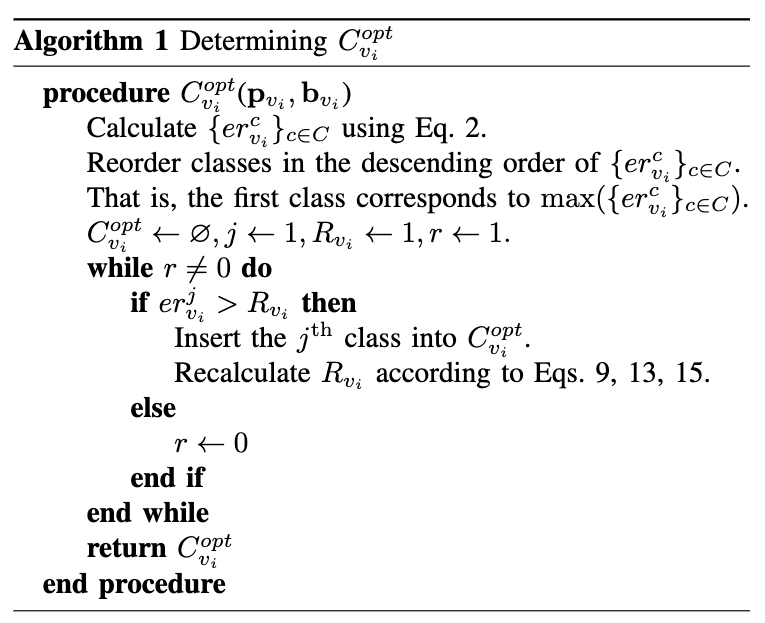
" style="width: 400px;"/>

In [53]:
def c_opt(p, b):
    er = expected_revenue(p, b)
    er_sort = torch.argsort(er, descending=True)
    c_opt_ = torch.zeros_like(p)
    j = 0
    reserve_rate_ = 1
    r = 1
    size = er_sort.shape[0]

    while r != 0:
        if j < size:
            if expected_revenue(p, b)[er_sort[j]] > reserve_rate_:
                c_opt_[er_sort[j]] = 1
                reserve_rate_ = reserve_rate(p, b, c_opt_)
                # Increasing j is missing in paper
                j += 1
            else:
                r = 0
        else:
            r = 0
    return c_opt_

Using *Algorithm 1* we can now calculate the average reserve rate for a mini batch:
$$
\mathrm{RR}=\frac{1}{|T r|} \sum_{v_{i} \in T r} R_{v_{i}}
$$

In [54]:
def average_reserve_rate(p, b):
    reserve_rates = torch.stack([
                        reserve_rate(p[i], b[i], c_opt(p[i], b[i])) 
                        for i, s in enumerate(torch.unbind(p, dim=0))
                    ], dim=0)

    return reserve_rates.mean()

### Example Training

In [55]:
# Train probabilities (based on expert annotations)
p_tr = torch.tensor([[0.5, 0.25, 0.25],
                     [0.25, 0.25, 0.5],
                     [0.25, 0.5, 0.25]], requires_grad=True)
# Train features
f_tr = torch.randn(3, 10, requires_grad=True)

In [56]:
n_in = 10
n_hidden = 100
n_out = 3

model = nn.Sequential(
          nn.Linear(n_in, n_hidden),
          nn.PReLU(1),
          nn.Linear(n_hidden, n_out),
          nn.Softmax(dim=1)
        )

In [57]:
lr = 0.05
epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    optimizer.zero_grad()
    preds = model(f_tr)
    loss = average_reserve_rate(p_tr, preds)
    print(f"Epoch: {epoch}, Loss: {loss.item()}")
    loss.backward()
    optimizer.step()

Epoch: 0, Loss: 0.6617286801338196
Epoch: 1, Loss: 0.26153457164764404
Epoch: 2, Loss: 0.25063225626945496
Epoch: 3, Loss: 0.2500403821468353
Epoch: 4, Loss: 0.2500031292438507
